In [34]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
def interpol_at_new_x(a_x, a_y, new_x):
    """
    Interpolation of discreet function F defined by set of point F(a_x)=a_y for new_x value
    and set to zero outside interval definition a_x

    :param a_x (float, (N)): F(a_x) = a_y, N size of a_x
    :param a_y (float, (N)): F(a_x) = a_y
    :param new_x (float, (M)): new value of x

    :return: F(new_x) (float, (M)): interpolation of F at new_x
    """
    from scipy import interpolate
    assert a_x.shape[0] > 0
    func_interpol = interpolate.interp1d(
        a_x, a_y, "cubic", bounds_error=False, fill_value=(0.0, 0.0)
    )
    return func_interpol(new_x)

lst=3
gala_file = "/home/grand/data/noise/30_250galactic.mat"
gala_file2 = '/home/grand/data/noise/Vocmax_30-250MHz_uVperMHz_hfss.npy'
gala_show = h5py.File(gala_file, "r")
gala_psd_dbm = np.transpose(gala_show["psd_narrow_huatu"])
gala_power_dbm = np.transpose(gala_show["p_narrow_huatu"])  # SL, dbm per MHz, P=mean(V*V)/imp with imp=100 ohms
#gala_voltage = np.transpose(gala_show["v_amplitude"])  # SL, microV per MHz, seems to be Vmax=sqrt(2*mean(V*V)), not std(V)=sqrt(mean(V*V))
gala_voltage = np.load(gala_file2)  # SL, microV per MHz, seems to be Vmax=sqrt(2*mean(V*V)), not std(V)=sqrt(mean(V*V))
gala_voltage = np.transpose(gala_voltage, (0, 2, 1))
# gala_power_mag = np.transpose(gala_show["p_narrow"])
gala_freq = gala_show["freq_all"]
v_amplitude_infile = gala_voltage[:, :, lst - 1]

In [35]:
gala_freq

<HDF5 dataset "freq_all": shape (221, 1), type "<f8">

In [36]:
len(gala_freq[:, 0])

221

In [37]:
#gala_voltage.shape

In [38]:
len(v_amplitude_infile[:, 0])

216

In [6]:
#gala_power_dbm.shape

In [14]:
"""
Simulation of galaxy emission in radio frequency
"""

import h5py
import numpy as np
from matplotlib import pyplot as plt
from grand import grand_add_path_data

def interpol_at_new_x(a_x, a_y, new_x):
    """
    Interpolation of discreet function F defined by set of point F(a_x)=a_y for new_x value
    and set to zero outside interval definition a_x

    :param a_x (float, (N)): F(a_x) = a_y, N size of a_x
    :param a_y (float, (N)): F(a_x) = a_y
    :param new_x (float, (M)): new value of x

    :return: F(new_x) (float, (M)): interpolation of F at new_x
    """
    from scipy import interpolate
    assert a_x.shape[0] > 0
    func_interpol = interpolate.interp1d(
        a_x, a_y, "cubic", bounds_error=False, fill_value=(0.0, 0.0)
    )
    return func_interpol(new_x)

def galactic_noise(f_lst, size_out, freqs_mhz, nb_ant, seed=None, du_type='GP300'):
    """
    This program is used as a subroutine to complete the calculation and
    expansion of galactic noise

    ..Authors:
      PengFei and Xidian group
      Modified by SN including different antenna models for leff
    :param f_lst: select the galactic noise LST at the LST moment
    :    type f_lst: float
    :param size_out: is the extended length
    :    type size_out: int
    :param freqs_mhz: array of output frequencies
    :    type freqs_mhz: float (nb freq,)
    :param nb_ant: number of antennas
    :    type nb_ant: int
    :param show_flag: print figure
    :    type show_flag: boll
    :param seed: if None, values are randomly generated as expected. 
                 if number, same set of randomly generated output. This is useful for testing.
    : du_type: Calculate the galactic noise for different antenna model simulations.
                 'GP300' (default) uses hfss simulations for leff
                 'GP300_nec' uses nec simulations for leff
                 'Gp300_mat' uses matlab simulations fro leff
    :return: FFT of galactic noise for all DU and components
    :rtype: float(nb du, 3, nb freq)
    """
    # TODO: why lst is an integer ?
    lst = int(f_lst)
    
    if du_type == 'GP300':
        gala_file = grand_add_path_data("noise/Vocmax_30-250MHz_uVperMHz_hfss.npy")
        gala_file1 = grand_add_path_data("noise/Pocmax_30-250_Watt_per_MHz_hfss.npy")
        gala_file2 = grand_add_path_data("noise/Pocmax_30-250_dBm_per_MHz_hfss.npy")
        gala_file3 = grand_add_path_data("noise/30_250galactic.mat")
        gala_show = h5py.File(gala_file3, "r")
        gala_voltage = np.load(gala_file)
        gala_voltage = np.transpose(gala_voltage, (0, 2, 1)) #micro Volts per MHz (max)
        gala_power_watt = np.load(gala_file1) 
        gala_power_watt = np.transpose(gala_power_watt, (0, 2, 1)) #watt per MHz
        gala_power_dbm = np.load(gala_file2)
        gala_power_dbm = np.transpose(gala_power_dbm, (0, 2, 1)) # dBm per MHz
        gala_freq = gala_show["freq_all"]

        """f_start = 30
        f_end = 250
        # TODO: 221 is the number of frequency ? why ? and comment to explain
        nb_freq = 221
        v_complex_double = np.zeros((nb_ant, size_out, 3), dtype=complex)
        galactic_v_time = np.zeros((nb_ant, size_out, 3), dtype=float)
        galactic_v_m_single = np.zeros((nb_ant, int(size_out / 2) + 1, 3), dtype=float)
        galactic_v_p_single = np.zeros((nb_ant, int(size_out / 2) + 1, 3), dtype=float)"""
        v_amplitude_infile = gala_voltage[:, :, lst - 1]
    
    elif du_type == 'GP300_nec':
        gala_file = grand_add_path_data("noise/Vocmax_30-250MHz_uVperMHz_nec.npy")
        gala_file1 = grand_add_path_data("noise/Pocmax_30-250_Watt_per_MHz_nec.npy")
        gala_file2 = grand_add_path_data("noise/Pocmax_30-250_dBm_per_MHz_nec.npy")
        gala_file3 = grand_add_path_data("noise/30_250galactic.mat")
        gala_show = h5py.File(gala_file3, "r")
        gala_voltage = np.load(gala_file)
        gala_voltage = np.transpose(gala_voltage, (0, 2, 1)) #micro Volts per MHz (max)
        gala_power_watt = np.load(gala_file1) 
        gala_power_watt = np.transpose(gala_power_watt, (0, 2, 1)) #watt per MHz
        gala_power_dbm = np.load(gala_file2)
        gala_power_dbm = np.transpose(gala_power_dbm, (0, 2, 1)) # dBm per MHz
        gala_freq = gala_show["freq_all"]
        """f_start = 30
        f_end = 250
        # TODO: 221 is the number of frequency ? why ? and comment to explain
        nb_freq = 221
        v_complex_double = np.zeros((nb_ant, size_out, 3), dtype=complex)
        galactic_v_time = np.zeros((nb_ant, size_out, 3), dtype=float)
        galactic_v_m_single = np.zeros((nb_ant, int(size_out / 2) + 1, 3), dtype=float)
        galactic_v_p_single = np.zeros((nb_ant, int(size_out / 2) + 1, 3), dtype=float)"""
        v_amplitude_infile = gala_voltage[:, :, lst - 1]
        
    elif du_type == 'GP300_mat':
        gala_file = grand_add_path_data("noise/Vocmax_30-250MHz_uVperMHz_mat.npy")
        gala_file1 = grand_add_path_data("noise/Pocmax_30-250_Watt_per_MHz_mat.npy")
        gala_file2 = grand_add_path_data("noise/Pocmax_30-250_dBm_per_MHz_mat.npy")
        gala_file3 = grand_add_path_data("noise/30_250galactic.mat")
        gala_show = h5py.File(gala_file3, "r")
        gala_voltage = np.load(gala_file)
        gala_voltage = np.transpose(gala_voltage, (0, 2, 1)) #micro Volts per MHz (max)
        gala_power_watt = np.load(gala_file1) 
        gala_power_watt = np.transpose(gala_power_watt, (0, 2, 1)) #watt per MHz
        gala_power_dbm = np.load(gala_file2)
        gala_power_dbm = np.transpose(gala_power_dbm, (0, 2, 1)) # dBm per MHz
        gala_freq = gala_show["freq_all"]
        """f_start = 30
        f_end = 250
        # TODO: 221 is the number of frequency ? why ? and comment to explain
        nb_freq = 221
        v_complex_double = np.zeros((nb_ant, size_out, 3), dtype=complex)
        galactic_v_time = np.zeros((nb_ant, size_out, 3), dtype=float)
        galactic_v_m_single = np.zeros((nb_ant, int(size_out / 2) + 1, 3), dtype=float)
        galactic_v_p_single = np.zeros((nb_ant, int(size_out / 2) + 1, 3), dtype=float)"""
        v_amplitude_infile = gala_voltage[:, :, lst - 1]

    # SL
    nb_freq = len(freqs_mhz)
    freq_res = freqs_mhz[1] - freqs_mhz[0]
    v_amplitude_infile = v_amplitude_infile * np.sqrt(freq_res)
    v_amplitude = np.zeros((nb_freq, 3))
    v_amplitude[:, 0] = interpol_at_new_x(gala_freq[:, 0], v_amplitude_infile[:, 0], freqs_mhz)
    v_amplitude[:, 1] = interpol_at_new_x(gala_freq[:, 0], v_amplitude_infile[:, 1], freqs_mhz)
    v_amplitude[:, 2] = interpol_at_new_x(gala_freq[:, 0], v_amplitude_infile[:, 2], freqs_mhz)

    '''
    a_nor = np.zeros((nb_ant, nb_freq, 3), dtype=float)
    phase = np.zeros((nb_ant, nb_freq, 3), dtype=float)
    v_complex = np.zeros((nb_ant, 3, nb_freq), dtype=complex)
    for l_ant in range(nb_ant):
        for l_fq in range(nb_freq):
            for l_axis in range(3):
                # Generates a normal distribution with 0 as the mean and
                # v_amplitude[l_fq, l_axis] as the standard deviation
                a_nor[l_ant, l_fq, l_axis] = np.random.normal(
                    loc=0, scale=v_amplitude[l_fq, l_axis]
                )
                # phase of random Gauss noise
                phase[l_ant, l_fq, l_axis] = 2 * np.pi * np.random.random_sample()
                # SL *size_out is because default scipy fft is normalised backward, *1/2 is because mean(cos(x)*cos(x)))
                v_complex[l_ant, l_axis, l_fq] = abs(a_nor[l_ant, l_fq, l_axis] * size_out / 2)
                v_complex[l_ant, l_axis, l_fq] *= np.exp(1j * phase[l_ant, l_fq, l_axis])
    '''

    # RK: above loop is replaced by lines below. Also np.random.default_rng(seed) is used instead of np.random.seed().
    #     if seed is a fixed number, same set of randomly generated number is produced. This is useful for testing.
    v_amplitude = v_amplitude.T
    rng   = np.random.default_rng(seed)     
    amp   = rng.normal(loc=0, scale=v_amplitude[np.newaxis,...], size=(nb_ant, 3, nb_freq))
    phase = 2 * np.pi * rng.random(size=(nb_ant, 3, nb_freq))
    v_complex = np.abs(amp * size_out / 2) * np.exp(1j * phase)

    return v_complex

In [6]:
seed=0
nb_ant = 300
size_out = 20
freqs_mhz = np.arange(30, 251, 1)
lst=18

In [7]:
galactic_noise(lst, size_out, freqs_mhz, nb_ant, seed=0, du_type='GP300_nec')

array([[[-3.12530053e+00+2.05274347e+00j,
          3.55623994e+00+1.62149259e+00j,
          4.19390880e+00+1.83519989e+01j, ...,
          1.46539732e+00+1.19925282e+01j,
         -3.55640550e+01+2.24558096e+01j,
         -5.77326941e-01+8.72690571e-01j],
        [ 6.71111716e+01-1.59544946e+01j,
         -1.19110551e+01+1.87520163e+01j,
         -1.91588388e+01+1.31254822e+01j, ...,
         -3.48623194e-02+1.07105368e+01j,
          4.55955491e+00+1.38472424e+01j,
         -1.40874984e+01+1.46454527e+01j],
        [ 2.71679927e+01+1.97407330e+01j,
          5.70902500e+01+6.59076347e+01j,
          4.59040972e+01+1.09337136e+01j, ...,
          4.34029895e+00-1.45714232e+01j,
          1.95397942e+01-1.72328132e-01j,
          5.49045445e+01-2.38590303e+01j]],

       [[-4.45651713e+00-4.99468879e+01j,
          1.31368901e+01+1.79637609e+01j,
          3.13384344e+01+1.01023119e+01j, ...,
         -5.84786856e+00-4.77007262e+00j,
          1.83422457e+00-2.65633261e+00j,
         

In [10]:
GN_nec=galactic_noise(lst, size_out, freqs_mhz, nb_ant, seed=0, du_type='GP300_nec')

In [11]:
GN_nec.shape

(300, 3, 221)

In [21]:
#plt.plot(freqs_mhz,abs(GN_nec[0,2,:]))
#plt.plot(freqs_mhz,abs(GN_nec[1,2,:]))
#plt.plot(freqs_mhz,abs(GN_nec[2,2,:]))
#plt.plot(freqs_mhz,abs(GN_nec[3,2,:]))
#plt.plot(freqs_mhz,abs(GN_nec[4,2,:]))
#plt.plot(freqs_mhz,abs(GN_nec[5,2,:]))
#plt.plot(freqs_mhz,abs(GN_nec[6,2,:]))

In [22]:
np.save("galaxy_oc_nec.npy",GN_nec)

In [2]:
#len(v_amplitude_infile)

In [16]:
gala_voltage.shape

(221, 3, 24)

In [17]:
gala_voltage2=np.load('/home/grand/data/noise/Vocmax_30-250MHz_uVperMHz_nec.npy')

In [18]:
gala_voltage2.shape

(221, 24, 3)

In [19]:
gala_voltage2 = np.transpose(gala_voltage2, (0, 2, 1))

In [20]:
gala_voltage2.shape

(221, 3, 24)

In [21]:
freqs_mhz = np.arange(30, 251, 1)
nb_freq = len(freqs_mhz)
freq_res = freqs_mhz[1] - freqs_mhz[0]
v_amplitude_infile = v_amplitude_infile * np.sqrt(freq_res)
v_amplitude = np.zeros((nb_freq, 3))
v_amplitude[:, 0] = interpol_at_new_x(gala_freq[:, 0], v_amplitude_infile[:, 0], freqs_mhz)
v_amplitude[:, 1] = interpol_at_new_x(gala_freq[:, 0], v_amplitude_infile[:, 1], freqs_mhz)
v_amplitude[:, 2] = interpol_at_new_x(gala_freq[:, 0], v_amplitude_infile[:, 2], freqs_mhz)

In [14]:
# RK: above loop is replaced by lines below. Also np.random.default_rng(seed) is used instead of np.random.seed().
#     if seed is a fixed number, same set of randomly generated number is produced. This is useful for testing.
seed=0
nb_ant = 300
size_out = 20
v_amplitude = v_amplitude.T
rng   = np.random.default_rng(seed)     
amp   = rng.normal(loc=0, scale=v_amplitude[np.newaxis,...], size=(nb_ant, 3, nb_freq))
phase = 2 * np.pi * rng.random(size=(nb_ant, 3, nb_freq))
v_complex = np.abs(amp * size_out / 2) * np.exp(1j * phase)

In [15]:
v_complex.shape

(300, 3, 221)

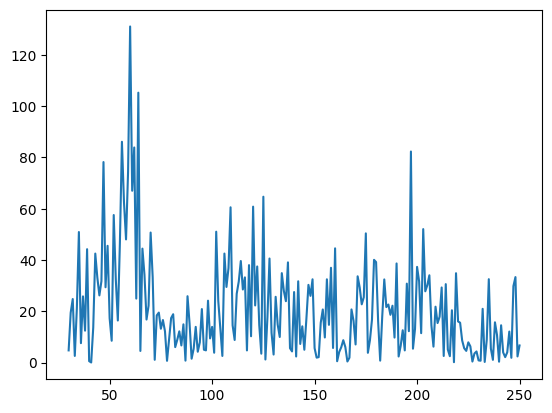

In [16]:
plt.plot(freqs_mhz,abs(v_complex[23,2,:]))